In [1]:
%matplotlib inline

In [2]:
import os
import sys
import git
import pathlib

import random

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # use GPU
# Using GPU during inference has deterministic results (same as CPU)

PROJ_ROOT_PATH = pathlib.Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
PROJ_ROOT =  str(PROJ_ROOT_PATH)
if PROJ_ROOT not in sys.path:
    sys.path.append(PROJ_ROOT)

from libs import utils, mnist32_cnn
from libs.constants import model_seeds

In [3]:
# Limit GPU growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [4]:
# Prepare dataset
# Combine test and train images together into one dataset
DATASET_PATH = str(pathlib.Path(PROJ_ROOT_PATH / "datasets" / "mnist.npz" ))
(train_images, train_labels), (test_images, test_labels) = mnist.load_data(path=DATASET_PATH)
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0  

all_images =np.concatenate([train_images, test_images], axis=0)
all_labels =np.concatenate([train_labels, test_labels], axis=0)
all_images = np.expand_dims(all_images, axis=-1)

# resize the input shape , i.e. old shape: 28, new shape: 32
image_x_size = 32
image_y_size = 32
all_images = tf.image.resize(all_images, [image_x_size, image_y_size]) 

In [5]:
model_type = "mnist32-cnn_1024_256_64"
imnum = 128*40
images = all_images[-imnum:]

In [6]:
conv_out_list= []
pool_out_list= []
flat_out_list= []
fc_0_out_list= []
fc_1_out_list= []
fc_2_out_list= []
op_layer_out_list= []

In [7]:
model_seeds = model_seeds[0:3]

In [8]:
for model_seed in model_seeds:
    # Get model
    model_instance = model_type + "-" + str(model_seed)
    dataset, model_arch, model_config, layer_widths, seed = utils.instancename2metadata(model_instance)
    model_meta_type, model_type, model_instance = utils.metadata2instancenames(dataset, model_arch, layer_widths, seed)

    model_folder = pathlib.Path(PROJ_ROOT_PATH / "models" / model_type)
    model_filename = model_instance + ".h5"
    model_file = pathlib.Path(model_folder/ model_filename)
    
    # Load model
    model = tf.keras.models.load_model(model_file)
    
    # Log output of each layer
    conv_out = model.layers[0](images)
    conv_out_list.append(conv_out)

    pool_out = model.layers[1](
                    model.layers[0](images))
    pool_out_list.append(pool_out)

    flat_out = model.layers[2](
                    model.layers[1](
                        model.layers[0](images)))
    flat_out_list.append(flat_out)

    fc_0_out = model.layers[3](
                    model.layers[2](
                        model.layers[1](
                            model.layers[0](images))))
    fc_0_out_list.append(fc_0_out)

    fc_1_out = model.layers[4](
                    model.layers[3](
                      model.layers[2](
                          model.layers[1](
                              model.layers[0](images)))))
    fc_1_out_list.append(fc_1_out)

    fc_2_out = model.layers[5](
                  model.layers[4](
                      model.layers[3](
                          model.layers[2](
                              model.layers[1](
                                  model.layers[0](images))))))
    fc_2_out_list.append(fc_2_out)

    op_layer_out = model.layers[6](
                      model.layers[5](
                          model.layers[4](
                              model.layers[3](
                                  model.layers[2](
                                      model.layers[1](
                                          model.layers[0](images)))))))
    op_layer_out_list.append(op_layer_out)

In [9]:
# fig, ax = plt.subplots()

# vp = ax.violinplot(D, [2, 4, 6], widths=2,
#                    showmeans=False, showmedians=False, showextrema=False)

In [10]:
all_conv_out = np.array(conv_out_list).flatten()
all_pool_out = np.array(pool_out_list).flatten()
all_flat_out = np.array(flat_out_list).flatten()
all_fc_0_out = np.array(fc_0_out_list).flatten()
all_fc_1_out = np.array(fc_1_out_list).flatten()
all_fc_2_out = np.array(fc_2_out_list).flatten()
all_op_layer_out = np.array(op_layer_out_list).flatten()

In [11]:
data = [
        all_conv_out,
        # all_pool_out,
        # all_flat_out,
        all_fc_0_out,
        all_fc_1_out,
        all_fc_2_out,
        all_op_layer_out,
       ]

In [12]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
cm = plt.get_cmap('tab20')
color_list = [cm(i*2-1) for i in range(cm.N)]

cmdark_list = [cm(i*2+1) for i in range(cm.N)]

Text(0.5, 0.98, 'Range of Activation Values for mnist32-cnn')

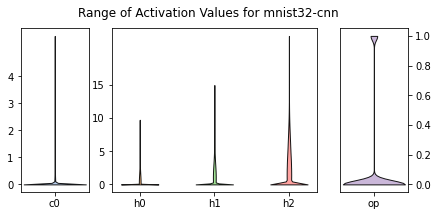

In [13]:
# Plot figure
fig_width = 3.125/0.9 * 2
fig_height = fig_width / 1.618 *0.7

# fig, axs = plt.subplots(nrows=1,
#                         ncols=3,
#                         figsize=[fig_width,fig_height], # in inches
#                         sharex=False)
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.05)

fig = plt.figure(figsize=[fig_width,fig_height]) # in inches)

gs = gridspec.GridSpec(1, 3, width_ratios=[1,3,1])
              
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

axs = [ax0, ax1, ax2]

c0plot = axs[0].violinplot(data[0],
                            showmeans=False, 
                            showmedians=False, 
                            showextrema=False)

for idx,pc in enumerate(c0plot['bodies']):
    pc.set_facecolor(cmdark_list[idx])
    pc.set_edgecolor('black')
    pc.set_alpha(0.9)
axs[0].set_xticks([1],["c0"])
axs[0].set_yticks([0,2,4,6])
    
fcplot = axs[1].violinplot(data[1:-1],
                            showmeans=False, 
                            showmedians=False, 
                            showextrema=False)

for idx,pc in enumerate(fcplot['bodies']):
    pc.set_facecolor(cmdark_list[idx+1])
    pc.set_edgecolor('black')
    pc.set_alpha(0.9)
axs[1].set_xticks([1,2,3],["h0","h1","h2"])
axs[1].set_yticks([0,10,20])


    
opplot = axs[2].violinplot(data[-1],
                            showmeans=False, 
                            showmedians=False, 
                            showextrema=False)

for idx,pc in enumerate(opplot['bodies']):
    pc.set_facecolor(cmdark_list[idx+4])
    pc.set_edgecolor('black')
    pc.set_alpha(0.9)
axs[2].set_xticks([1],["op"])
axs[2].yaxis.tick_right()

fig.suptitle("Range of Activation Values for mnist32-cnn")
# fig.supxlabel("Layer")
# fig.tight_layout()


In [20]:
axs[0].set_yticks([0,2,4,6],[0,2,4,6])
axs[1].set_yticks([0,10,20],[0,10,20])

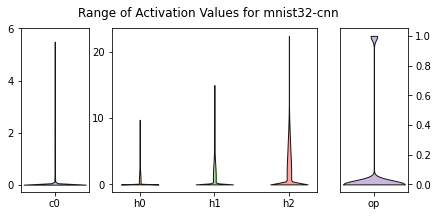

In [21]:
fig

In [22]:
# Get notebook path
import ipynbname
nb_path = str(ipynbname.path())
fig_filename_tag = "mnist32-cnn--activation_range"
fig_folder = pathlib.Path(PROJ_ROOT_PATH / "figures")
pathlib.Path(fig_folder).mkdir(parents=True, exist_ok=True)
fig_filename = pathlib.Path(fig_folder/ fig_filename_tag)
print(fig_filename)
fig.savefig(fig_filename,
    # pathlib.Path(fig_filename).with_suffix(".png"), 
            dpi=300, 
            bbox_inches='tight', 
            transparent=True, 
            metadata={"genfilepath": nb_path})

/repos/faulty_cnn/figures/mnist32-cnn--activation_range


In [15]:
# # Plot figure
# fig_width = 3.125/0.8 *2.5
# fig_height = fig_width / 1.618 *0.5

# fig, axs = plt.subplots(nrows=1,
#                         ncols=3,
#                         figsize=[fig_width,fig_height], # in inches
#                         sharex=False)
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.05)

# axs[0].violinplot(load_data[0],
#                 showmeans=False, 
#                 showmedians=False, 
#                 showextrema=False)

In [16]:
# c0_out_log = np.log10(all_conv_out + 1e-30)
# fc_0_out_log = np.log10(all_fc_0_out + 1e-30)
# fc_1_out_log = np.log10(all_fc_1_out + 1e-30)
# fc_2_out_log = np.log10(all_fc_2_out + 1e-30)
# op_layer_out_log = np.log10(all_op_layer_out + 1e-30)

# log_data = [
#     c0_out_log,
#     fc_0_out_log,
#     fc_0_out_log,
#     fc_0_out_log,
#     op_layer_out_log,
# ]

In [17]:
# # Plot figure
# fig_width = 3.125/0.8 *2.5
# fig_height = fig_width / 1.618 *0.5

# fig, axs = plt.subplots(nrows=1,
#                         ncols=3,
#                         figsize=[fig_width,fig_height], # in inches
#                         sharex=False)
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.05)

# # axs.violinplot(load_data,np.arange(len(load_data)),
# #               showmeans=False, showmedians=False, showextrema=False)

# box0=axs[0].boxplot(load_data[1:-1],
#                 notch=True,
#                     showfliers=not False,
#                     patch_artist=True,
#                     # whis=0.75,
#                     # showmeans=True,
#                    )
# for patch, color in zip(box0['boxes'], color_list):
#     patch.set_facecolor(color)
    

# box0=axs[1].boxplot(load_data[0],
#                 notch=True,
#                     showfliers=not False,
#                     patch_artist=True,
#                     # whis=0.75,
#                     # showmeans=True,
#                    )
# for patch, color in zip(box0['boxes'], color_list[3:]):
#     patch.set_facecolor(color)
    
# box0=axs[2].boxplot(load_data[-1],
#                 notch=True,
#                 showfliers= not False,
#                 patch_artist=True,
#                 # whis=0.75,
#                 # showmeans=True,
#                    )
# for patch, color in zip(box0['boxes'], color_list[4:]):
#     patch.set_facecolor(color)

# # axs[2].violinplot(load_data[-1],
# #               showmeans=False, showmedians=False, showextrema=False)

# # axs.set_xticks(np.arange(5)+1,["c0", "fc0", "fc1", "fc2", "op"])

# # axs.set_yscale('log')